## Plot model performance

Visualize performance on different models from a CSV summary file.

In [8]:
import pathlib
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import seaborn as sns
import wandb

from utils import BodeColorPalette, get_runs_as_list
bode_palette = BodeColorPalette()

In [9]:
# settings
sns.set_theme(context="paper", 
              style="white", 
              font_scale=0.7,
              rc={"savefig.transparent": True, 
                  "axes.grid": False, 
                  "axes.spines.bottom": True,
                  "axes.spines.left": False,
                  "axes.spines.right": False,
                  "axes.spines.top": False,
                  "font.family":'sans-serif',
                  "font.sans-serif":["Helvetica", "Arial"],
                  "xtick.major.pad": 0.0,
                  "xtick.minor.pad": 0.0,
                  "ytick.major.pad": 0.0,
                  "ytick.minor.pad": 0.0,
                  "axes.labelweight": "bold",
                  "axes.labelpad": 2.5,  # standard is 4.0
                  "axes.xmargin": .05,
                 }, 
             )

# more settings for all plots
errorbar = "se"  # standard error of the mean
errwidth = .9
errcolor = "black"
capsize = .1  # size of the end of the errorbar
linewidth = 1.  # width of the outline of barplot

palette = [
    bode_palette.blues[0], 
    bode_palette.oranges[0],
    bode_palette.blues[2],
    bode_palette.oranges[2],
    bode_palette.blues[3],
    bode_palette.oranges[3]
]


### Get data from wandb API

In [10]:
summary_list, config_list, tag_list, name_list  = get_runs_as_list(filters={"$or":
                                                             [{"jobType": "training"},
                                                              {"jobType": "hparam_best"}
                                                             ]})
df_all = pd.json_normalize(config_list).merge(pd.json_normalize(summary_list), left_index=True, right_index=True)
df_all["tags"] = tag_list
df_all["run_id"] = name_list
df_all["run_group"] = [s.rsplit("_", maxsplit=1)[0] for s in name_list]
df_all["Model+Features"] = df_all["name"] + "/" + df_all["decoder.global_features"].str.join("+").str.replace("None", "CGR")

In [11]:
# check available experiments by split
for tag, row in df_all.groupby("tags")[["experiment_id"]].agg(set).iterrows():
    print(tag, "-->", row["experiment_id"])

('0D',) --> {'JG1116', 'JG1135', 'JG1128', 'JG1160', nan, 'JG1109', 'JG1131', 'JG1100', 'JG1106', 'JG1117', 'JG1115'}
('0D_1.25',) --> {'JG1141', 'JG1159', 'JG1147', 'JG1153'}
('0D_10',) --> {'JG1150', 'JG1138', 'JG1156', 'JG1144'}
('0D_2.5',) --> {'JG1146', 'JG1158', 'JG1140', 'JG1152'}
('0D_20',) --> {'JG1149', 'JG1143', 'JG1155', 'JG1137'}
('0D_40',) --> {'JG1142', 'JG1148', 'JG1154', 'JG1136'}
('0D_5',) --> {'JG1157', 'JG1145', 'JG1139', 'JG1151'}
('1D',) --> {'JG1118', 'JG1121', 'JG1123', 'JG1101', 'JG1125', nan, 'JG1104', 'JG1129', 'JG1132', 'JG1126'}
('1D_10',) --> {'JG1164'}
('1D_2.5',) --> {'JG1166'}
('1D_20',) --> {'JG1163'}
('1D_40',) --> {'JG1162', 'JG1168'}
('1D_5',) --> {'JG1165'}
('1D_80',) --> {'JG1167', 'JG1161'}
('2D',) --> {'JG1127', 'JG1112', 'JG1102', 'JG1130', nan, 'JG1133', 'JG1124', 'JG1105', 'JG1119', 'JG1122'}
('3D',) --> {'JG1107', 'JG1120', 'JG1134', 'JG1108', 'JG1114', nan, 'JG1103', 'JG1110', 'JG1111', 'JG1113'}


In [12]:
# set dir where we will save plots
analysis_dir = pathlib.Path("results")

## 0D split

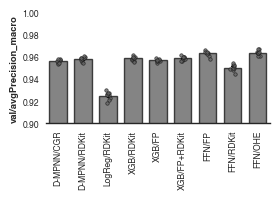

In [135]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "0D"
# choose the colorscheme
fill_color = '0.4'  # grey
stroke_color = '0.1'  # almost black

# choose the data to plot
experiment_ids = [
    "JG1100",
    "JG1160",
    #"JG1135",  # GCN is very low compared to others
    "JG1106",
    "JG1109",
    "JG1128",
    "JG1131",
    "JG1115",
    "JG1116",
    "JG1117",
    
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(2.8,2))
sns.barplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    errorbar=errorbar,
    errwidth=errwidth,
    errcolor=errcolor,
    capsize=capsize,
    color=fill_color,
    edgecolor=stroke_color,
    linewidth=linewidth,
    alpha=.8,
    width=.7,
)

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=2.5,
              alpha=.8
             )

#ax.axhline(0.963872, ls=":", color="black", linewidth=.7)
ax.set_xlabel(None)
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.9, 1))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()

fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.png", dpi=300)

In [136]:
df_plot.groupby("Model+Features")["val/avgPrecision_macro"].agg([np.mean, np.std]).sort_values(by="mean", ascending=False)

,mean,std
Model+Features,,
FFN/OHE,0.963872,0.002128
FFN/FP,0.963128,0.002338
XGB/FP+RDKit,0.958831,0.001758
XGB/RDKit,0.958611,0.001926
D-MPNN/RDKit,0.958101,0.001935
XGB/FP,0.956987,0.001382
D-MPNN/CGR,0.956286,0.001568
FFN/RDKit,0.950380,0.002953
LogisticRegression/RDKit,0.925079,0.003638


In [137]:
# is the best model significantly better than the rest?
best = "FFN/OHE"
x = df_plot.loc[df_plot["Model+Features"] == best].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
for i in df_plot["Model+Features"].drop_duplicates():
    if i != best:
        y = df_plot.loc[df_plot["Model+Features"] == i].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
        print(i, ":\t", wilcoxon(x, y, alternative="two-sided"))

D-MPNN/CGR :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
D-MPNN/RDKit :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
LogisticRegression/RDKit :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
XGB/RDKit :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
XGB/FP :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
XGB/FP+RDKit :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
FFN/FP :	 WilcoxonResult(statistic=3.0, pvalue=0.01953125)
FFN/RDKit :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)


## 1D split

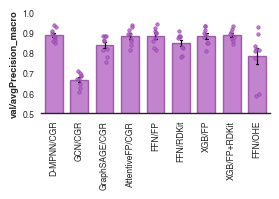

In [35]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "1D"
# choose the colorscheme
fill_color = (189/256, 87/256, 213/256)
stroke_color = (140/256, 67/256, 158/256)

# choose the data to plot
experiment_ids = [
    "JG1101",
    "JG1104",
    "JG1121",
    "JG1123",
    "JG1125",
    "JG1126",
    "JG1129",
    "JG1132",
    "JG1118",

]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(2.8,2))
sns.barplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    errorbar=errorbar,
    errwidth=errwidth,
    errcolor=errcolor,
    capsize=capsize,
    color=fill_color,
    edgecolor=stroke_color,
    linewidth=linewidth,
    alpha=.8,
    width=.7,
)

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=2.5,
              alpha=.8
             )

#ax.axhline(0.5, ls="--", color=bode_palette.blue, linewidth=.7)
ax.set_xlabel(None)
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.5, 1))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.png", dpi=300)

In [36]:
df_plot.groupby("Model+Features")["val/avgPrecision_macro"].agg([np.mean, np.std]).sort_values(by="mean", ascending=False)

,mean,std
Model+Features,,
D-MPNN/CGR,0.890784,0.030425
XGB/FP+RDKit,0.889293,0.028826
XGB/FP,0.883578,0.042024
FFN/FP,0.883107,0.043262
AttentiveFP/CGR,0.882898,0.041379
FFN/RDKit,0.850365,0.046617
GraphSAGE/CGR,0.838695,0.048111
FFN/OHE,0.784098,0.120060
GCN/CGR,0.667339,0.034510


In [37]:
# is the best model significantly better than the rest?
best = "D-MPNN/CGR"
x = df_plot.loc[df_plot["Model+Features"] == best].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
for i in df_plot["Model+Features"].drop_duplicates():
    if i != best:
        y = df_plot.loc[df_plot["Model+Features"] == i].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
        print(i, ":\t", wilcoxon(x, y, alternative="two-sided"))

GCN/CGR :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
GraphSAGE/CGR :	 WilcoxonResult(statistic=2.0, pvalue=0.01171875)
AttentiveFP/CGR :	 WilcoxonResult(statistic=14.0, pvalue=0.359375)
FFN/FP :	 WilcoxonResult(statistic=16.0, pvalue=0.49609375)
FFN/RDKit :	 WilcoxonResult(statistic=4.0, pvalue=0.02734375)
XGB/FP :	 WilcoxonResult(statistic=17.0, pvalue=0.5703125)
XGB/FP+RDKit :	 WilcoxonResult(statistic=20.0, pvalue=0.8203125)
FFN/OHE :	 WilcoxonResult(statistic=3.0, pvalue=0.01953125)


## 2D split

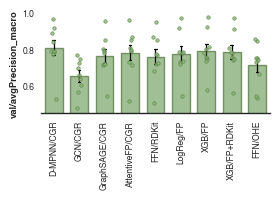

In [38]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "2D"
# choose the colorscheme
fill_color = (
    135/256,
    186/256,
    112/256,
)

stroke_color = (92/256, 124/256, 76/256)

# choose the data to plot
experiment_ids = [
    "JG1102",
    "JG1105",
    "JG1122",
    "JG1124",
    "JG1127",
    "JG1112",
    "JG1130",
    "JG1133",
    "JG1119",

]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()

# set plot
fig, ax = plt.subplots(figsize=(2.8,2))
sns.barplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    errorbar=errorbar,
    errwidth=errwidth,
    errcolor=errcolor,
    capsize=capsize,
    color=fill_color,
    edgecolor=stroke_color,
    linewidth=linewidth,
    alpha=.8,
    width=.7,
)

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=2.5,
              alpha=.8
             )

#ax.axhline(0.5, ls="--", color=bode_palette.blue, linewidth=.7)
ax.set_xlabel(None)
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.45, 1))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.png", dpi=300)

In [39]:
df_plot.groupby("Model+Features")["val/avgPrecision_macro"].agg([np.mean, np.std]).sort_values(by="mean", ascending=False)

,mean,std
Model+Features,,
D-MPNN/CGR,0.809626,0.124337
XGB/FP,0.790416,0.112848
XGB/FP+RDKit,0.784771,0.115233
AttentiveFP/CGR,0.781057,0.123634
LogisticRegression/FP,0.774621,0.122331
GraphSAGE/CGR,0.764278,0.112075
FFN/RDKit,0.759928,0.126657
FFN/OHE,0.713682,0.114297
GCN/CGR,0.655483,0.094320


In [40]:
# is the best model significantly better than the rest?
best = "D-MPNN/CGR"
x = df_plot.loc[df_plot["Model+Features"] == best].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
for i in df_plot["Model+Features"].drop_duplicates():
    if i != best:
        y = df_plot.loc[df_plot["Model+Features"] == i].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
        print(i, ":\t", wilcoxon(x, y, alternative="two-sided"))

GCN/CGR :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
GraphSAGE/CGR :	 WilcoxonResult(statistic=3.0, pvalue=0.01953125)
AttentiveFP/CGR :	 WilcoxonResult(statistic=3.0, pvalue=0.01953125)
FFN/RDKit :	 WilcoxonResult(statistic=1.0, pvalue=0.0078125)
LogisticRegression/FP :	 WilcoxonResult(statistic=7.0, pvalue=0.07421875)
XGB/FP :	 WilcoxonResult(statistic=12.0, pvalue=0.25)
XGB/FP+RDKit :	 WilcoxonResult(statistic=10.0, pvalue=0.1640625)
FFN/OHE :	 WilcoxonResult(statistic=1.0, pvalue=0.0078125)


## 3D split

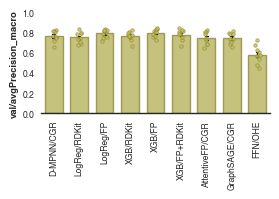

In [139]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "3D"
# choose the colorscheme
fill_color = (198/256, 193/256, 80/256)

stroke_color = (142/256, 136/256, 58/256)

# choose the data to plot
experiment_ids = [
    "JG1103",
    "JG1107",
    "JG1108",
    "JG1110",
    "JG1111",
    "JG1134",
    "JG1113",
    "JG1114",
    "JG1120",
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(2.8,2))
sns.barplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    errorbar=errorbar,
    errwidth=errwidth,
    errcolor=errcolor,
    capsize=capsize,
    color=fill_color,
    edgecolor=stroke_color,
    linewidth=linewidth,
    alpha=.8,
    width=.7,
)

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=2.5,
              alpha=.8
             )

#ax.axhline(0.5, ls="--", color=bode_palette.blue, linewidth=.7)
ax.set_xlabel(None)
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0, 1))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.png", dpi=300)

In [140]:
df_plot.groupby("Model+Features")["val/avgPrecision_macro"].agg([np.mean, np.std]).sort_values(by="mean", ascending=False)

,mean,std
Model+Features,,
XGB/FP,0.800110,0.041297
LogisticRegression/FP,0.794498,0.042385
XGB/FP+RDKit,0.782625,0.054720
D-MPNN/CGR,0.769681,0.056595
XGB/RDKit,0.768620,0.046068
LogisticRegression/RDKit,0.755103,0.054808
AttentiveFP/CGR,0.747098,0.061750
GraphSAGE/CGR,0.745838,0.055996
FFN/OHE,0.584521,0.087108


In [141]:
# is the best model significantly better than the rest?
best = "XGB/FP"
x = df_plot.loc[df_plot["Model+Features"] == best].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
for i in df_plot["Model+Features"].drop_duplicates():
    if i != best:
        y = df_plot.loc[df_plot["Model+Features"] == i].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
        print(i, ":\t", wilcoxon(x, y, alternative="two-sided"))

D-MPNN/CGR :	 WilcoxonResult(statistic=5.0, pvalue=0.0390625)
LogisticRegression/RDKit :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
LogisticRegression/FP :	 WilcoxonResult(statistic=15.0, pvalue=0.42578125)
XGB/RDKit :	 WilcoxonResult(statistic=1.0, pvalue=0.0078125)
XGB/FP+RDKit :	 WilcoxonResult(statistic=4.0, pvalue=0.02734375)
AttentiveFP/CGR :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
GraphSAGE/CGR :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
FFN/OHE :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)


## 0D restricted data splits

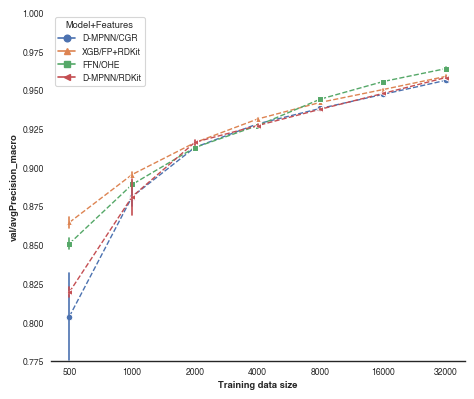

In [31]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
tags = ["0D_1.25", "0D_2.5", "0D_5", "0D_10", "0D_20", "0D_40", "0D"]

# choose the data to plot
experiment_ids = [
        [  # _1.25
            "JG1147",  # D-MPNN+CGR
            "JG1153",  # XGB+FP+RDKit
            "JG1141",  # FFN+OHE
            "JG1159",  # D-MPNN+CGR+RDKit
    ],
        [  # _2.5
            "JG1146",  # D-MPNN+CGR
            "JG1152",  # XGB+FP+RDKit
            "JG1140",  # FFN+OHE
            "JG1158",  # D-MPNN+CGR+RDKit
    ],
        [  # _5
            "JG1145",  # D-MPNN+CGR
            "JG1151",  # XGB+FP+RDKit
            "JG1139",  # FFN+OHE
            "JG1157",  # D-MPNN+CGR+RDKit
    ],
        [  # _10
            "JG1144",  # D-MPNN+CGR
            "JG1150",  # XGB+FP+RDKit
            "JG1138",  # FFN+OHE
            "JG1156",  # D-MPNN+CGR+RDKit
    ],
        [  # _20
            "JG1143",  # D-MPNN+CGR
            "JG1149",  # XGB+FP+RDKit
            "JG1137",  # FFN+OHE
            "JG1155",  # D-MPNN+CGR+RDKit
    ],
        [  # _40
            "JG1142",  # D-MPNN+CGR
            "JG1148",  # XGB+FP+RDKit
            "JG1136",  # FFN+OHE
            "JG1154",  # D-MPNN+CGR+RDKit
    ],
        [  # full
            "JG1100",  # D-MPNN+CGR
            "JG1131",  # XGB+FP+RDKit
            "JG1117",  # FFN+OHE
            "JG1160",  # D-MPNN+CGR+RDKit n/a for full 0D split
    ],
]

sample_counts = {  # mean number of training samples for each split 
    "0D_1.25": 500,
    "0D_2.5": 1000,
    "0D_5": 2000,
    "0D_10": 4001,
    "0D_20": 8003,
    "0D_40": 16006,
    "0D": 32014,
}

exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=metric,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=False,
    ls="--",
    linewidth=linewidth,
    markers=["o", "^", "s", "<"],
)

ax.set_xlabel("Training data size")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0.775, 1))
ax.set_xticks(
    [500, 1000, 2000, 4000, 8000, 16000, 32000], 
    ['500', '1000', '2000', '4000', '8000', '16000', '32000']
)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_0D_restricted-data_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_0D_restricted-data_models_{metric.replace('/', '_')}.png", dpi=300)

## 1D restricted data splits

/tmp/ipykernel_889510/472933128.py:66: UserWarning: The markers list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(


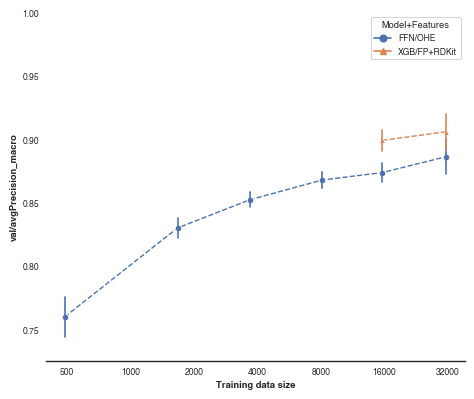

In [28]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
tags = ["1D_2.5", "1D_5", "1D_10", "1D_20", "1D_40", "1D_80"]

# choose the data to plot
experiment_ids = [
        [  # _2.5
            "JG1178",  # D-MPNN+CGR
            "JG1172",  # XGB+FP+RDKit
            "JG1166",  # FFN+OHE
            "JG1184",  # D-MPNN+CGR+RDKit
    ],
        [  # _5
            "JG1177",  # D-MPNN+CGR
            "JG1171",  # XGB+FP+RDKit
            "JG1165",  # FFN+OHE
            "JG1183",  # D-MPNN+CGR+RDKit
    ],
        [  # _10
            "JG1176",  # D-MPNN+CGR
            "JG1170",  # XGB+FP+RDKit
            "JG1164",  # FFN+OHE
            "JG1182",  # D-MPNN+CGR+RDKit
    ],
        [  # _20
            "JG1175",  # D-MPNN+CGR
            "JG1169",  # XGB+FP+RDKit
            "JG1163",  # FFN+OHE
            "JG1181",  # D-MPNN+CGR+RDKit
    ],
        [  # _40
            "JG1174",  # D-MPNN+CGR
            "JG1168",  # XGB+FP+RDKit
            "JG1162",  # FFN+OHE
            "JG1180",  # D-MPNN+CGR+RDKit
    ],
        [  # _80
            "JG1173",  # D-MPNN+CGR
            "JG1167",  # XGB+FP+RDKit
            "JG1161",  # FFN+OHE
            "JG1179",  # D-MPNN+CGR+RDKit
    ],
]

sample_counts = {  # mean number of training samples for each split 
    "1D_2.5": 487,
    "1D_5": 1668,
    "1D_10": 3680,
    "1D_20": 8107,
    "1D_40": 15648,
    "1D_80": 31250,
}

exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=metric,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=False,
    ls="--",
    linewidth=linewidth,
    markers=["o", "^", "s", "<"],
)

ax.set_xlabel("Training data size")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0.725, 1))
ax.set_xticks(
    [500, 1000, 2000, 4000, 8000, 16000, 32000], 
    ['500', '1000', '2000', '4000', '8000', '16000', '32000']
)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_1D_restricted-data_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_1D_restricted-data_models_{metric.replace('/', '_')}.png", dpi=300)

In [16]:
df_plot_x["x"]

18    1D_2.5
19    1D_2.5
20    1D_2.5
21    1D_2.5
22    1D_2.5
       ...  
67     1D_80
68     1D_80
69     1D_80
70     1D_80
71     1D_80
Name: x, Length: 72, dtype: object